In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
from datetime import *
%matplotlib inline

In [3]:
def grab_data(ticker, stdevs, start, end):
    ticker = pdr.DataReader(ticker, 'iex', start, end)
    dates = pd.to_datetime(ticker.index)
    ticker["date"] = dates
    ticker['returns'] = (ticker.close - ticker.open)/ticker.open
    mover = []
    thres = stdevs*np.std(ticker['returns'])
    for i in ticker['returns']:
        if abs(i) > thres:
            mover += [True]
        else: 
            mover += [False]
    ticker['mover'] = mover
    return ticker

In [4]:
start = datetime(2013, 11, 16)
end = datetime(2018, 11, 15)
#etfs = ['UNG', "VXX", 'SPY', "GLD", 'USO', "WEAT", 'SPXL', "FAS", 'GDXJ', "IAU", 'TQQQ', "SLV", 'NUGT', "IYR", 'YINN']
etfs = ['VXX', 'SPXL']
etfs_database = {}
for i in etfs:
    etfs_database[i] = grab_data(i, 2, start, end)
    

5y
5y


NameError: name 'vxx' is not defined

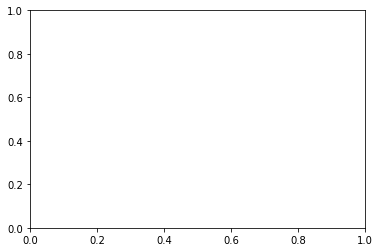

In [5]:
fig, vxx_graph = plt.subplots()
vxx_graph.plot_date(vxx.date, vxx.returns)
vxx_graph.plot_date(vxx_movers.date, vxx_movers.returns, c = 'r')
vxx_graph.grid()
sum([vxx.date[1] - vxx.date[3]], timedelta())/1



In [ ]:
def make_graph(ticker, stdevs):
    fig, graph = plt.subplots()
    graph.plot_date(ticker.date, ticker.returns)
    graph.plot_date(ticker[ticker['mover']].date, ticker[ticker['mover']].returns, c = 'r')
    graph.grid()
    x1, x2, y1, y2 = graph.axis()
    graph.axis([x1, x2, -.3, .3])
    return graph

for i in [etfs_database['VXX'], etfs_database['SPXL']] :
    make_graph(i, 3)
    plt.title('returns over time')

                   

Okayyyy, so here's what we're going for:

Null: Fat tails are _uniforimly_ or _normally_ distributed.

Alternate: The things appear in big clusters, and specifically, they whip around. 

Point: If I can prove that a big move one way (specifically in commodities and volatility) is clustered with/paired with/indicative of a big move in the _opposite_ direction the next day, I serve to make a lot of money. 

What I don't want: For it to be a *fucking coin flip*. 

Let's get cracking. 

What we need to know: 
- One: Whether these moves are, in fact, _usually_ opposite.
- Two: Whether these moves are, in fact, clustered. 
- Three: Whether these moves are or are not clustered depending on product. 
- Four: Whether high kurtosis has an effect 
    (I know it will on the freq of big moves, Idk about the diretionality)

In [ ]:
vxx = etfs_database['VXX']

In [ ]:
kflay = sum([vxx.date[1] - vxx.date[3]], timedelta())/1
kflay.days

In [ ]:
derka =np.arange(0, len(vxx_movers.date), 2)
vxx_movers['date'][0] - vxx_movers['date'][1]
close = [vxx_movers['date'][i+1] - vxx_movers['date'][i] for i in derka if (i+1 < len(vxx_movers.date))]

In [ ]:
def build_cluster(etf_movers_selected, current_cluster= []):
    movers = etf_movers_selected
    cluster_list = []
    #-1 to avoid index error + irrelavant because you can't know when the next big move is
    for i in np.arange(0, len(movers.date) - 1): 
        move_date = movers['date'][i]
        next_move = movers['date'][i +1]
        current_cluster += [move_date]
        if (next_move - move_date).days <= 5:
            current_cluster += [next_move]
        else:
            cluster_list += [current_cluster]
            current_cluster = []
    return cluster_list
            
            
def get_unique_clusters(etf_cluster, start):
    def minus_start(some_date):
        return [(i - start).days for i in some_date]  
    days = list(map(minus_start, etf_cluster))
    unique_days = [list(set(i)) for i in days]
    return unique_days



In [ ]:
vxx_cluster = build_cluster(etfs_database['VXX'][etfs_database['VXX']['mover']])
clusters_database ={}
clusters_database['VXX'] = get_distance(vxx_cluster, start)

def make_cluster_base(etf_database):
    cluster_base = {}
    for i in etf_database.keys():
        movers = etf_database[i][etf_database[i]['mover']] #selecting movers for build cluster,
        cluster_base[i] = get_unique_clusters(build_cluster(movers), etf_database[i].date[0])
    return cluster_base

def fraction_cluster(cluster_list):
    #returns a the fraction of clusters in a list of flagged moves, grouped by distance
    cluster_count = 0
    for cluster in cluster_list:
            if len(cluster) != 1:
                cluster_count +=1 
    return cluster_count/len(cluster_list)

def get_cluster_fracs(cluster_database):
    #retruns a dict of fractions of clusters freom a cluster database
    fraction_clusters = {}
    for name in cluster_database:
        frac_cluster = fraction_cluster(cluster_database[name]) 
        fraction_clusters[name] = frac_cluster
    return fraction_clusters



#get_cluster_fracs(cluster_base_sample)

In [6]:
def get_resampled_data(etf_database, repetitions = 1000, sample_size = 30):
    resampled_data_dict = {}
    for i in etf_database.keys():
        resampled_data = []
        for j in np.arange(repetitions):
            sample_clusters_to_mean = []
            for k in np.arange(sample_size):
                ticker = etfs_database[i]
                resampled_df = ticker.sample(len(ticker[ticker['mover']]))
                resampled_df_sorted = resampled_df.sort_index()
                resampled_cluster = build_cluster(resampled_df_sorted)
                sample_clusters_to_mean += [fraction_cluster(resampled_cluster)]
            resampled_data += [np.mean(sample_clusters_to_mean)]
        resampled_data_dict[i] = resampled_data
    return resampled_data_dict



NameError: name 'small_sample' is not defined

In [8]:
cluster_base_sample = make_cluster_base(etfs_database)
observed = get_cluster_fracs(cluster_base_sample)

def make_cluster_graph(etf_database, sample_database):
    cluster_baser = make_cluster_base(etf_database)
    observed = get_cluster_fracs(cluster_baser)
    txter = open('analysis/v_important_cluster_analysis', 'w+')
    for i in etf_database.keys():
        resampled_data = sample_database[i]
        plt.axvline(np.percentile(resampled_data, .5), color = 'purple', marker = '|')
        plt.axvline(np.percentile(resampled_data, 99.5), color = 'purple', marker = '|')
        plt.axvline(observed[i], color = 'red')
        plt.hist(np.array(resampled_data), bins = 17)
        plt.xlabel('Fraction Clustered')
        plt.ylabel('Count')
        plt.title('Clusters of ' + str(i))
        plt.grid()
        plt.text(0.25, -4, "Purple is 99% confidence at random; Red is the observed.", ha = 'center')
        stds = np.round(observed[i]/np.std(resampled_data), 2)
        text = "That's " + str(stds) + " standard deviations away, in case you were wondering."
        plt.text(0.25, -5.3, text , ha = 'center')
        clusterimgfilename = ('images/'+ i + 'clusterchart.png')
        plt.savefig(clusterimgfilename, bbox_inches="tight")
        plt.close()
        text = "{}: The observed percentage of clusters, {}%, for {} was {} standard deviations from the mean value of {}%.".format(i, 100*np.round(observed[i], 4), i, stds, 100*np.round(np.mean(resampled_data), 4))
        txter.write(text + "\n\n")
    txter.close()
        

NameError: name 'make_cluster_base' is not defined

In [9]:
make_cluster_graph(etfs_database, small_sample)

NameError: name 'make_cluster_graph' is not defined

In [12]:
vxx =etfs_database['VXX']

In [13]:
vxx[vxx['mover']]

,open,high,low,close,volume,date,returns,mover
date,,,,,,,,
2014-02-06,852.48,851.360,773.4400,776.1600,2942164,2014-02-06,-0.089527,True
2014-07-17,442.08,488.640,436.0000,478.8784,4874159,2014-07-17,0.083239,True
2014-10-08,518.72,523.200,470.8800,472.8000,4122881,2014-10-08,-0.088526,True
2014-10-09,478.72,517.280,475.5200,515.3600,5381184,2014-10-09,0.076537,True
2014-10-10,518.56,574.240,507.8400,573.6000,6601603,2014-10-10,0.106140,True
2014-10-13,563.84,634.560,554.2400,632.9600,6666681,2014-10-13,0.122588,True
2014-10-16,708.16,713.600,629.7600,645.2800,7771420,2014-10-16,-0.088793,True
2014-10-20,620.80,624.160,568.6400,569.6000,3769631,2014-10-20,-0.082474,True
2014-10-22,523.20,571.520,516.6400,568.3200,5809752,2014-10-22,0.086239,True
